In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /home/Sinner/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [3]:
df = df.dropna()

In [4]:
def text_normalize(text):
    text = text.lower()

    text = re.sub(r'^rt[\s]+', '', text)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    text = re.sub(r'[^\w\s]', '', text)

    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ''.join(words)

    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ''.join(words)

    return text

In [5]:
df.loc[:, 'clean_text'] = df['clean_text'].apply(text_normalize)
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [6]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

In [7]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] =  1

In [8]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [9]:
def softmax(z):
    exp_z = np.exp(z)

    return exp_z / exp_z.sum(axis=1)[:, None]

In [10]:
def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)

    return y_hat

In [11]:
def compute_loss(y_hat, y):
    n = y.size

    return (-1 / n) * np.sum(y * np.log(y_hat))

In [12]:
def compute_gradient(X, y, y_hat):
    n = y.size

    return np.dot(X.T, (y_hat - y)) / n

In [13]:
def update_theta(theta, gradient, lr):
    return theta - lr * gradient

In [14]:
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()

    return acc

In [15]:
lr = 0.01
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

In [16]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.371	Validation loss: 0.371

EPOCH 2:	Training loss: 0.371	Validation loss: 0.371

EPOCH 3:	Training loss: 0.371	Validation loss: 0.371

EPOCH 4:	Training loss: 0.371	Validation loss: 0.371

EPOCH 5:	Training loss: 0.371	Validation loss: 0.371

EPOCH 6:	Training loss: 0.371	Validation loss: 0.371

EPOCH 7:	Training loss: 0.371	Validation loss: 0.371

EPOCH 8:	Training loss: 0.371	Validation loss: 0.371

EPOCH 9:	Training loss: 0.371	Validation loss: 0.371

EPOCH 10:	Training loss: 0.371	Validation loss: 0.371

EPOCH 11:	Training loss: 0.371	Validation loss: 0.371

EPOCH 12:	Training loss: 0.371	Validation loss: 0.370

EPOCH 13:	Training loss: 0.371	Validation loss: 0.370

EPOCH 14:	Training loss: 0.371	Validation loss: 0.370

EPOCH 15:	Training loss: 0.371	Validation loss: 0.370

EPOCH 16:	Training loss: 0.371	Validation loss: 0.370

EPOCH 17:	Training loss: 0.371	Validation loss: 0.370

EPOCH 18:	Training loss: 0.371	Validation loss: 0.370

EPOCH 19:	Training

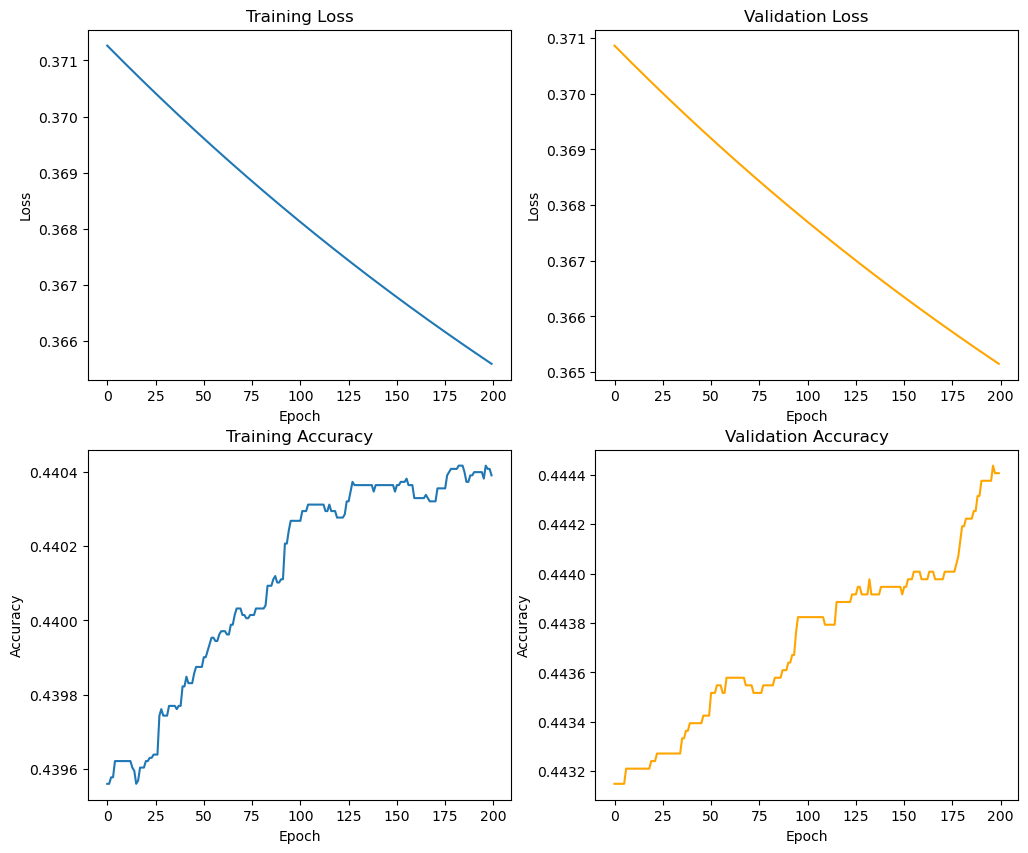

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [18]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Accuracy: 0.4444069460636927
Accuracy: 0.44333312879671105
